In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.datasets import make_blobs

In [34]:
# we create 40 separable points
random_state = 2**3
x, y = make_blobs(n_samples=40, centers=2, random_state=random_state)

In [35]:
# fit the model, don't regularize for illustration purposes
model = svm.SVC(kernel='rbf', C=100, gamma='scale')
model.fit(x, y)

SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [36]:
x0_mean = x[:, 0].mean()
x0_min = x[:, 0].min() - x0_mean * 0.5
x0_max = x[:, 0].max() + x0_mean * 0.5
x1_mean = x[:, 1].mean()
x1_min = x[:, 1].min() - x1_mean * 0.5
x1_max = x[:, 1].max() + x1_mean * 0.5

In [37]:
from sklearn.metrics.pairwise import rbf_kernel

In [38]:
x_test = np.array([[6.0, 1.0], [8.0, 2.0], [10.0, 10.0]], dtype=np.float32)
pred_test = model.predict(x_test)
print(pred_test)

[1 1 0]


In [39]:
y_sign = np.array([[-1 if yy == 0 else 1 for yy in pred_test]], dtype=np.float32).T

In [40]:
sup_x = model.support_vectors_ # 8x2
dual_alpha = model.dual_coef_ # 1x8
beta = model.intercept_
gamma = model._gamma

print('sup_x', sup_x.shape)
print('dual_alpha', dual_alpha.shape)
print('gamma', gamma)

print('x test', x_test.shape)

sup_x (8, 2)
dual_alpha (1, 8)
gamma 0.04089030167538266
x test (3, 2)


In [41]:
print('df=', model.decision_function(x_test))

df= [ 1.20393357  1.07982708 -0.91837726]


In [57]:
rbf = rbf_kernel(sup_x, x_test, gamma=gamma) # 8x3
print(rbf.shape)

# check rbf result on single sample
# x_repeat = np.repeat([x_test[0]], sup_x.shape[0], axis=0)
# np.array([np.exp(-np.sum((sup_x-x_repeat)**2, axis=1)*gamma)]).T

# Single feature
rbf0 = rbf_kernel(sup_x, [x_test[0]], gamma=gamma)
nabla0 = 2.0 * gamma * np.sum(((sup_x[:, 0] - x_test[0][0]) * dual_alpha).flatten() * rbf0.flatten())
print(nabla0)

grad_df = None
for ww, xx in zip((2.0 * gamma * dual_alpha.T * rbf).T, x_test):
    if grad_df is None:
        grad_df = ww @ sup_x-xx
    else:
        grad_df = np.vstack((grad_df, ww @ sup_x-xx))

print('grad_df\n', grad_df)

adversarial = x_test + 0.5 * y_sign * grad_df

(8, 3)
0.04164055711110742
grad_df
 [[ -5.37396653  -0.94026124]
 [ -7.35623793  -1.99396731]
 [-10.58062782 -10.79954468]]


In [46]:
print('x_test\n', x_test)
pred_test = model.predict(x_test)
print('pred_test\n', pred_test)
print('adversarial\n', adversarial)
ad_pred = model.predict(adversarial)
print('ad_pred\n', ad_pred)

x_test
 [[ 6.  1.]
 [ 8.  2.]
 [10. 10.]]
pred_test
 [1 1 0]
adversarial
 [[ 3.31301674  0.52986938]
 [ 4.32188104  1.00301635]
 [15.29031391 15.39977234]]
ad_pred
 [1 1 0]


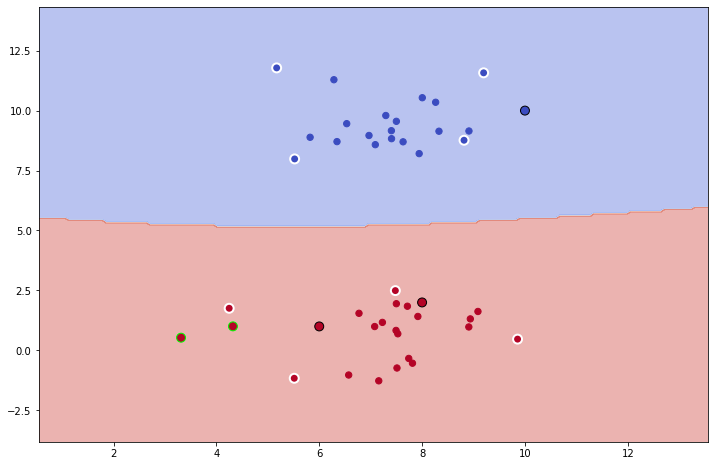

In [47]:
XX, YY = np.mgrid[x0_min:x0_max:200j, x1_min:x1_max:200j]
Z = model.predict(np.c_[XX.ravel(), YY.ravel()])
Z = Z.reshape(XX.shape)

figsize = np.array(plt.rcParams["figure.figsize"]) * 2
plt.figure(figsize=figsize.tolist())

plt.contourf(XX, YY, Z, cmap='coolwarm', alpha=0.4, zorder=1)

plt.scatter(x[:, 0], x[:, 1], c=y, cmap='coolwarm', edgecolor='face', s=40, zorder=2)
plt.scatter(model.support_vectors_[:, 0], model.support_vectors_[:, 1], c=y[model.support_], cmap='coolwarm', edgecolors='white', linewidths=2, s=80, zorder=10)

pred_test = model.predict(x_test)
plt.scatter(x_test[:, 0], x_test[:, 1], c=pred_test, cmap='coolwarm', edgecolor='k', s=80, zorder=20)
plt.scatter(adversarial[:, 0], adversarial[:, 1], c=ad_pred, cmap='coolwarm', edgecolor='lime', s=80, zorder=20)

plt.xlim(x0_min, x0_max)
plt.ylim(x1_min, x1_max)
plt.show()